In [76]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
import math

In [77]:
df_data_1, df_data_2, df_data_3  = pd.read_csv('HR_comma_sep.csv'), pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv'), pd.read_csv('turnover.csv', encoding = 'ISO-8859-1')
df_model_1, df_model_2, df_model_3 = df_data_1.copy(),df_data_2.copy(),df_data_3.copy()

In [78]:
df_model_1.describe(include=np.object)

,Department,salary
count,14999,14999
unique,10,3
top,sales,low
freq,4140,7316


In [79]:
df_model_2.describe(include=np.object)

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
count,1470,1470,1470,1470,1470,1470,1470,1470,1470
unique,2,3,3,6,2,9,3,1,2
top,No,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,No
freq,1233,1043,961,606,882,326,673,1470,1054


In [80]:
df_model_3.describe(include=np.object)

,gender,industry,profession,traffic,coach,head_gender,greywage,way
count,1129,1129,1129,1129,1129,1129,1129,1129
unique,2,16,15,8,3,2,2,3
top,f,Retail,HR,youjs,no,m,white,bus
freq,853,289,757,318,683,584,1002,681


In [81]:
# deklarasi kolom yang akan dihapus
drop2 = ['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18']
# drop kolom yang akan dihapus
df_model_2 = df_model_2.drop(drop2,axis=1)

In [82]:
# rename kolom target
df_model_1 = df_model_1.rename(columns={'left': 'churn'})
df_model_2 = df_model_2.rename(columns={'Attrition': 'churn'})
df_model_3 = df_model_3.rename(columns={'event': 'churn'})

# rename kolom treatment
df_model_1 = df_model_1.rename(columns={'promotion_last_5years': 'treatment'})
df_model_2 = df_model_2.rename(columns={'OverTime': 'treatment'})
df_model_3 = df_model_3.rename(columns={'coach': 'treatment'})

In [83]:
# deklarasi kolom string
string1, string2, string3 = ['salary'], ['churn', 'treatment', 'BusinessTravel'], ['treatment']
# observasi data unique
for col in string1:
    display(col, df_model_1[col].unique())
for col in string2:
    display(col, df_model_2[col].unique())
for col in string3:
    display(col, df_model_3[col].unique())

'salary'

array(['low', 'medium', 'high'], dtype=object)

'churn'

array(['Yes', 'No'], dtype=object)

'treatment'

array(['Yes', 'No'], dtype=object)

'BusinessTravel'

array(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'], dtype=object)

'treatment'

array(['no', 'yes', 'my head'], dtype=object)

In [84]:
# Deklarasi target dan treatment dataset 1
df_model_1.salary = df_model_1.salary.map({'low': 0, 'medium': 1, 'high':2})

In [85]:
# Deklarasi target dan treatment dataset 2
df_model_2.churn = df_model_2.churn.map({'Yes': 1, 'No': 0})
df_model_2.treatment = df_model_2.treatment.map({'Yes': 0, 'No': 1})
# Deklarasi BusinessTravel
df_model_2.BusinessTravel = df_model_2.BusinessTravel.map({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently':2})

In [86]:
# Deklarasi target dan treatment dataset 3
df_model_3.treatment = df_model_3.treatment.map({'yes': 0, 'no': 1, 'my head':2})
df_model_3 = df_model_3.loc[df_model_3.treatment <=1].reset_index(drop=True)

In [87]:
# inverse nilai treatment untuk mendapatkan korelasi treatment yang positif terhadap kebocoran karyawan
df_model_1.treatment = df_model_1.treatment.replace({0: 1, 1: 0})
df_model_2.treatment = df_model_2.treatment.replace({0: 1, 1: 0})
df_model_3.treatment = df_model_3.treatment.replace({0: 1, 1: 0})

In [88]:
# One-Hot Encoding untuk ketiga dataset:
df_model_1, df_model_2, df_model_3 = pd.get_dummies(df_model_1), pd.get_dummies(df_model_2), pd.get_dummies(df_model_3)

In [89]:
# kalkulasi korelasi treatment 
def korelasi_treatment(df:pd.DataFrame):
    correlation = df[['treatment','churn']].corr(method ='pearson') 
    return(pd.DataFrame(round(correlation.loc['churn'] * 100,2)))

In [90]:
display(korelasi_treatment(df_model_1).iloc[0,0])
display(korelasi_treatment(df_model_2).iloc[0,0])
display(korelasi_treatment(df_model_3).iloc[0,0])

6.18

24.61

4.0

<h1> 3.3.4. Pendeklarasian Target Class

In [91]:
def deklarasi_target_class(df:pd.DataFrame):
    """Fungsi untuk mendeklarasikan target class
    """
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df.treatment == 0) & (df.churn == 0),'target_class'] = 1 
    #TN:
    df.loc[(df.treatment == 1) & (df.churn == 1),'target_class'] = 2 
    #TR:
    df.loc[(df.treatment == 1) & (df.churn == 0),'target_class'] = 3 
    return df

In [92]:
df_model_1, df_model_2, df_model_3 = deklarasi_target_class(df_model_1), \
deklarasi_target_class(df_model_2), deklarasi_target_class(df_model_3)

<h1> 3.4. Hasil Pemodelan Machine Learning

In [107]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
def split_data(df_model:pd.DataFrame):
    """Split data menjadi data train dan data test
    """
    X = df_model.drop(['churn','target_class'],axis=1)
    y = df_model.churn
    z = df_model.target_class
    X_train, X_test, \
    y_train, y_test, \
    z_train, z_test = train_test_split(X,
                                       y,
                                       z,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=df_model['treatment'])
    return X_train,X_test, y_train, y_test, z_train, z_test


def proses_machine_learning(df:pd.DataFrame,
                            X_train:pd.DataFrame,
                            X_test:pd.DataFrame,
                            y_train:pd.DataFrame,
                            y_test:pd.DataFrame,
                            z_train:pd.DataFrame,
                            z_test:pd.DataFrame):
    """Proses machine learning dengan algoritma XGB
    """
    # Siapkan dataframe baru hasil prediksi
    hasil_prediksi = pd.DataFrame(X_test).copy()
    
    
    # Proses train model CP
    model_cp \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)  
    # Proses prediksi model CP
    prediksi_cp \
    = model_cp.predict(X_test.drop('treatment',axis=1))
    probabilitas_cp \
    = model_cp.predict_proba(X_test.drop('treatment', axis=1))
    hasil_prediksi['prediksi_churn'] = prediksi_cp
    hasil_prediksi['proba_churn'] = probabilitas_cp[:,1]
    
    
    # Proses train model Uplift
    model_uplift \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), z_train)
    # Proses prediksi model Uplift
    prediksi_uplift \
    = model_uplift.predict(X_test.drop('treatment', axis=1))
    probabilitas_uplift \
    = model_uplift.predict_proba(X_test.drop('treatment', axis=1))
    hasil_prediksi['prediksi_target_class'] = prediksi_uplift
    hasil_prediksi['proba_CN'] = probabilitas_uplift[:,0] 
    hasil_prediksi['proba_CR'] = probabilitas_uplift[:,1] 
    hasil_prediksi['proba_TN'] = probabilitas_uplift[:,2] 
    hasil_prediksi['proba_TR'] = probabilitas_uplift[:,3]
    hasil_prediksi['skor_uplift'] = hasil_prediksi.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')  
    
    
    # Memasukkan validasi churn dan target class ke dataframe
    hasil_prediksi['churn'] = y_test
    hasil_prediksi['target_class'] = z_test
    return hasil_prediksi


def model_machine_learning(df_model:pd.DataFrame):
    """Menggabungkan proses split dan machine learning
    """
    X_train, X_test, y_train, y_test, z_train, z_test = split_data(df_model)
    hasil_prediksi = proses_machine_learning(df_model,
                                             X_train,
                                             X_test,
                                             y_train,
                                             y_test,
                                             z_train,
                                             z_test)
    return hasil_prediksi

In [108]:
# Proses pemodelan machine learning
hasil_prediksi_1 = model_machine_learning(df_model_1)
hasil_prediksi_2 = model_machine_learning(df_model_2)
hasil_prediksi_3 = model_machine_learning(df_model_3)

<h1> 3.5.1. Evaluasi Akurasi

In [109]:
from sklearn.metrics import accuracy_score
def evaluasi_akurasi(df:pd.DataFrame):
    """Evaluasi akurasi hasil prediksi
    """
    akurasi_cp = accuracy_score(df['churn'],
                                df['prediksi_churn'])
    print('Akurasi model CP: %.2f%%' % (akurasi_cp * 100.0))
    akurasi_uplift = accuracy_score(df['target_class'],
                                    df['prediksi_target_class'])
    print('Akurasi model Uplift: %.2f%%' % (akurasi_uplift * 100.0))

In [110]:
# Proses evaluasi akurasi
evaluasi_akurasi(hasil_prediksi_1)
evaluasi_akurasi(hasil_prediksi_2)
evaluasi_akurasi(hasil_prediksi_3)

Akurasi model CP: 97.18%
Akurasi model Uplift: 95.20%
Akurasi model CP: 85.94%
Akurasi model Uplift: 64.85%
Akurasi model CP: 61.63%
Akurasi model Uplift: 48.16%


<h1> 3.5.2. Evaluasi QINI

In [42]:
def pengurutan_data(df:pd.DataFrame):
    """Function untuk mengurutkan data
    """
    # Siapkan dataframe baru untuk model CP dan Uplift
    df_c = pd.DataFrame({'n':[], 'target_class':[]})
    df_u = df_c.copy()
    df_c['target_class'] = df['target_class']
    df_u['target_class'] = df['target_class']
    # Menambahkan urutan kuantil
    df_c['n'] = df.proba_churn.rank(pct=True, ascending=False)
    df_u['n'] = df.skor_uplift.rank(pct=True, ascending=False)
    df_c['skor'] = df['proba_churn']
    df_u['skor'] = df['skor_uplift']
    # Proses pengurutan data    
    df_c = df_c.sort_values(by='n').reset_index(drop=True)
    df_u = df_u.sort_values(by='n').reset_index(drop=True)
    df_c['model'], df_u['model'] = 'CP', 'Uplift'
    return df_c, df_u


def perhitungan_qini(df:pd.DataFrame):
    """Function untuk menghitung nilai QINI
    """
    # Variabel control group dan treatment group
    C, T = sum(df['target_class'] <= 1), sum(df['target_class'] >= 2)
    df['cr'] = 0
    df['tr'] = 0
    df.loc[df.target_class  == 1,'cr'] = 1
    df.loc[df.target_class  == 3,'tr'] = 1
    df['cr/c'] = df.cr.cumsum() / C
    df['tr/t'] = df.tr.cumsum() / T
    # Hitung & masukkan nilai QINI kedalam dataframe
    df['uplift'] = df['tr/t'] - df['cr/c']
    df['random'] = df['n'] * df['uplift'].iloc[-1]
    # Tambahkan q0 kedalam dataframe
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    QINI = pd.concat([q0, df]).reset_index(drop = True)
    return QINI


def penggabungan_data(df_c:pd.DataFrame, df_u:pd.DataFrame):
    """Function untuk menambahkan kolom model dan
    menggabungkan dataframe menjadi satu
    """
    df_u['model'] = 'Uplift'
    df_c['model'] = 'CP'
    df = pd.concat([df_u, df_c]).sort_values(by='n').reset_index(drop = True)
    return df


def plot_qini(df:pd.DataFrame):
    """Function untuk mem-plotkan QINI
    """
    # Menentukan data yang akan divisualisasikan
    order = ['Uplift','CP']
    ax = sns.lineplot(x='n', y=df.uplift, hue='model', data=df,
                      style='model', palette=['red','deepskyblue'],
                      style_order=order, hue_order = order)
    # Pengaturan tampilan plot
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proporsi yang ditargetkan',fontsize=15)
    plt.ylabel('Nilai Uplift',fontsize=15)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=12)
    ax.tick_params(labelsize=15)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    ax.plot([0,1], [0,df.loc[len(df) - 1,'uplift']],'--', color='grey')
    return ax


def evaluasi_qini(hasil_prediksi:pd.DataFrame):
    """Function untuk menggabungkan semua proses evaluasi QINI
    """
    df_c, df_u = pengurutan_data(hasil_prediksi)
    qini_c, qini_u = perhitungan_qini(df_c), perhitungan_qini(df_u)
    qini = penggabungan_data(qini_c, qini_u)
    ax = plot_qini(qini)
    return ax

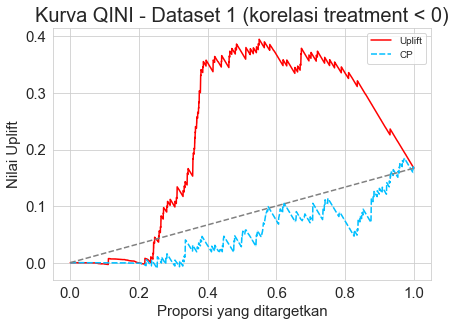

In [43]:
# hasil evaluasi QINI untuk dataset 1
evaluasi_qini(hasil_prediksi_1)
plt.title('Kurva QINI - Dataset 1 (korelasi treatment < 0)',fontsize=20)
plt.savefig('QINI_1_n.pdf', bbox_inches='tight')

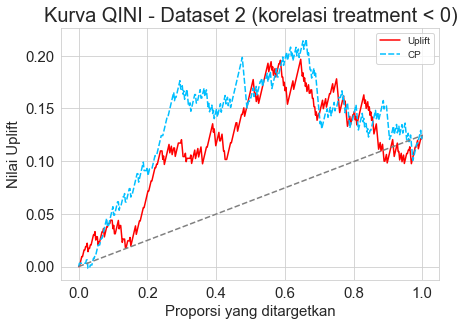

In [44]:
# hasil evaluasi QINI untuk dataset 2
evaluasi_qini(hasil_prediksi_2)
plt.title('Kurva QINI - Dataset 2 (korelasi treatment < 0)',fontsize=20)
plt.savefig('QINI_2_n.pdf', bbox_inches='tight')

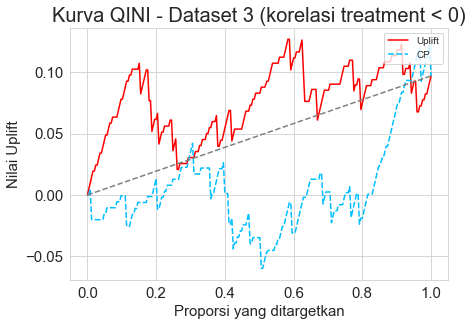

In [45]:
# hasil evaluasi QINI untuk dataset 3
evaluasi_qini(hasil_prediksi_3)
plt.title('Kurva QINI - Dataset 3 (korelasi treatment < 0)',fontsize=20)
plt.savefig('QINI_3_n.pdf', bbox_inches='tight')

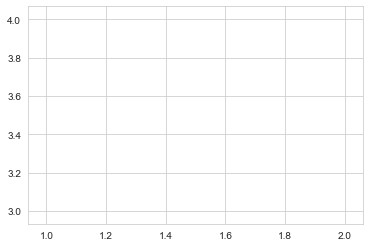

In [46]:
# fig, ax = plt.subplots(1,1)
# # dummy plots, just to get the Path objects
# a = ax.scatter([1,2],[3,4], marker='s')
# b = ax.scatter([1,2],[3,4], marker='^')
# square_mk, = a.get_paths()
# triangle_up_mk, = b.get_paths()
# a.remove()
# b.remove()
# def distribusi_target_class(df_1:pd.DataFrame, df_2:pd.DataFrame, df_3:pd.DataFrame, target_class:str):
#     df_1['dataset'] = 'Dataset 1'
#     df_2['dataset'] = 'Dataset 2'
#     df_3['dataset'] = 'Dataset 3'
#     df = pd.concat([df_1, df_2, df_3])
#     df = df.sort_values(by='n')[:round(len(df)/4)]
#     ax = sns.swarmplot(data=df[df.target_class==target_class], x='dataset', y='n', 
#                   hue='model', palette=['deepskyblue','red'], 
#                       hue_order=['CP', 'Uplift'], order=['Dataset 1', 'Dataset 2', 'Dataset 3'], size=5)
#     collections = ax.collections
#     unique_colors = np.unique(collections[0].get_facecolors(), axis=0)
#     markers = [square_mk, triangle_up_mk]  # this array must be at least as large as the number of unique colors
#     for collection in collections:
#         paths = []
#         for current_color in collection.get_facecolors():
#             for possible_marker,possible_color in zip(markers, unique_colors):
#                 if np.array_equal(current_color,possible_color):
#                     paths.append(possible_marker)
#                     break
#         collection.set_paths(paths)
        
        
#     ax.tick_params(labelsize=15)   
#     ax.legend(collections[-2:],pd.unique(df.model))  
#     plt.ylabel('Proporsi yang Ditargetkan',fontsize=20)
#     plt.xlabel('')
#     plt.subplots_adjust(right=1.5)
#     plt.subplots_adjust(top=1)
#     plt.legend(fontsize='large')
# #     plt.savefig('CN.pdf', bbox_inches='tight')
#     return ax

In [47]:
# distribusi_target_class(df_1, df_2, df_3, 0)
# plt.title('Distribusi karyawan tipe CN (korelasi treatment < 0)',fontsize=25, y=1.05)
# plt.savefig('CN_p.pdf', bbox_inches='tight')

NameError: name 'df_1' is not defined

In [ ]:
# distribusi_target_class(df_1, df_2, df_3, 1)
# plt.title('Distribusi karyawan tipe CR (korelasi treatment < 0)',fontsize=25, y=1.05)
# plt.savefig('CR_p.pdf', bbox_inches='tight')

In [ ]:
# distribusi_target_class(df_1, df_2, df_3, 2)
# plt.title('Distribusi karyawan tipe TN (korelasi treatment < 0)',fontsize=25, y=1.05)
# plt.savefig('TN_p.pdf', bbox_inches='tight')

In [ ]:
# distribusi_target_class(df_1, df_2, df_3, 3)
# plt.title('Distribusi karyawan tipe TR (korelasi treatment < 0)',fontsize=25, y=1.05)
# plt.savefig('TR_p.pdf', bbox_inches='tight')